# ssoaspect

In [1]:
#source /export/ciao/bin/ciao.bash -o
PFILES="./param;$ASCDS_INSTALL/param:$ASCDS_INSTALL/contrib/param"
mkdir -p ./param
ASCDS_WORK_PATH=./


## download

In [2]:
/bin/rm -rf 3726 
download_chandra_obsid 3726 evt2,asol,eph1,msk 



  Type     Format      Size  0........H.........1  Download Time Average Rate
  ---------------------------------------------------------------------------
  asol     fits        7 Mb  ####################          < 1 s  74928.7 kb/s
  evt2     fits        3 Mb  ####################          < 1 s  64556.3 kb/s
  eph1     fits      282 Kb  ####################          < 1 s  9266.2 kb/s
  eph1     fits      275 Kb  ####################          < 1 s  15806.1 kb/s
  eph1     fits      259 Kb  ####################          < 1 s  12597.8 kb/s
  eph1     fits       28 Kb  ####################          < 1 s  2085.9 kb/s
  eph1     fits       13 Kb  ####################          < 1 s  1106.7 kb/s
  msk      fits        5 Kb  ####################          < 1 s  440.1 kb/s

      Total download size for ObsId 3726 = 11 Mb
      Total download time for ObsId 3726 = < 1 s



In [3]:
find 3726 -type f -print | xargs -I@ mv -fv @ ./ 
gunzip -f *fits.gz


'3726/primary/pcadf03726_000N001_asol1.fits.gz' -> './pcadf03726_000N001_asol1.fits.gz'
'3726/primary/acisf03726N005_evt2.fits.gz' -> './acisf03726N005_evt2.fits.gz'
'3726/primary/orbitf162216300N001_eph1.fits.gz' -> './orbitf162216300N001_eph1.fits.gz'
'3726/primary/jupiterf162475200N001_eph1.fits.gz' -> './jupiterf162475200N001_eph1.fits.gz'
'3726/secondary/ephem/lunarf162216300N001_eph1.fits.gz' -> './lunarf162216300N001_eph1.fits.gz'
'3726/secondary/ephem/solarf162216300N001_eph1.fits.gz' -> './solarf162216300N001_eph1.fits.gz'
'3726/secondary/ephem/anglesf03726_000N005_eph1.fits.gz' -> './anglesf03726_000N005_eph1.fits.gz'
'3726/secondary/acisf03726_000N005_msk1.fits.gz' -> './acisf03726_000N005_msk1.fits.gz'


## Choosing

In [4]:
/bin/ls *eph1.fits

anglesf03726_000N005_eph1.fits	 orbitf162216300N001_eph1.fits
jupiterf162475200N001_eph1.fits  solarf162216300N001_eph1.fits
lunarf162216300N001_eph1.fits


In [5]:
dmkeypar acisf03726N005_evt2.fits TSTART echo+

162488245.80274


## Run sso_freeze

In [6]:
/bin/ls -1 pcadf*fits > pcad_asol1.lis
cat pcad_asol1.lis

pcadf03726_000N001_asol1.fits


In [7]:
pset sso_freeze infile=acisf03726N005_evt2.fits
pset sso_freeze scephemfile=orbitf162216300N001_eph1.fits
pset sso_freeze ssoephemfile=jupiterf162475200N001_eph1.fits
pset sso_freeze asolfile=@pcad_asol1.lis
pset sso_freeze ocsolfile=3726_oc_asol1.fits
pset sso_freeze outfile=3726_jupiter_oc.fits
sso_freeze mode=h clob+


[1] 31358
[1]+  Done                    ds9 "3726_jupiter_oc.fits[bin=ocx,ocy]" -scale log -saveimage png ds9_01.png


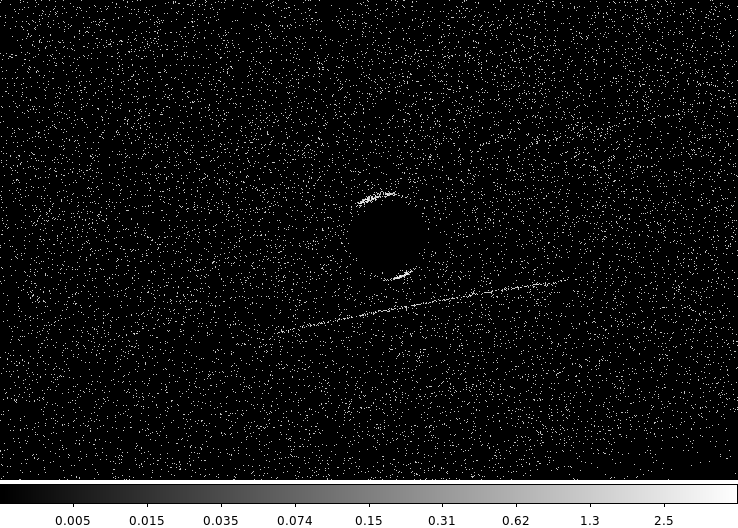

In [8]:
ds9 "3726_jupiter_oc.fits[bin=ocx,ocy]" \
  -scale log \
  -saveimage png ds9_01.png &
sleep 10
xpaset -p ds9 quit

display < ds9_01.png

## Edit Header


In [9]:
cat << EOM > edits.lis 
#add
RA_NOM = 0.0
DEC_NOM = 0.0
RA_PNT = 0.0
DEC_PNT = 0.0
EOM

dmhedit 3726_jupiter_oc.fits filelist=edits.lis

## Create Expmap

### 1. Make the aspect histogram

In [10]:
pset asphist infile="3726_oc_asol1.fits[OCSOL][cols time,ra=ocra,dec=ocdec,roll,dy,dz,dtheta][ASPSOL]"
pset asphist outfile=3726_oc_asphist.fits 
pset asphist evtfile=3726_jupiter_oc.fits
asphist mode=h clob+


### 2. Calculate the Instrument Map

In [11]:
pset mkinstmap obsfile="3726_jupiter_oc.fits[EVENTS]"
pset mkinstmap outfile=3726_oc_instmap.fits
pset mkinstmap maskfile=acisf03726_000N005_msk1.fits
pset mkinstmap detsubsys=ACIS-S3
pset mkinstmap pixelgrid="1:1024:#1024,1:1024:#1024"
pset mkinstmap pbkfile=NONE dafile=NONE
pset mkinstmap spectrumfile=NONE
pset mkinstmap monoenergy=1.0
mkinstmap mode=h clob+

### 3. Calculate the Exposure Map

In [12]:
pset mkexpmap instmapfile=3726_oc_instmap.fits 
pset mkexpmap outfile=3726_oc_expmap.fits
pset mkexpmap xygrid="2048:6144:#512,2048:6144:#512"
pset mkexpmap asphistfile=3726_oc_asphist.fits
pset mkexpmap useavgaspect=no
pset mkexpmap normalize=no
mkexpmap mode=h clob+

In [13]:
dmhedit 3726_oc_expmap.fits file= op=add key=BUNIT value="cm**2 sec"

[1] 31490
[1]+  Done                    ds9 3726_oc_expmap.fits -cmap a -zoom 2 -saveimage png ds9_03.png


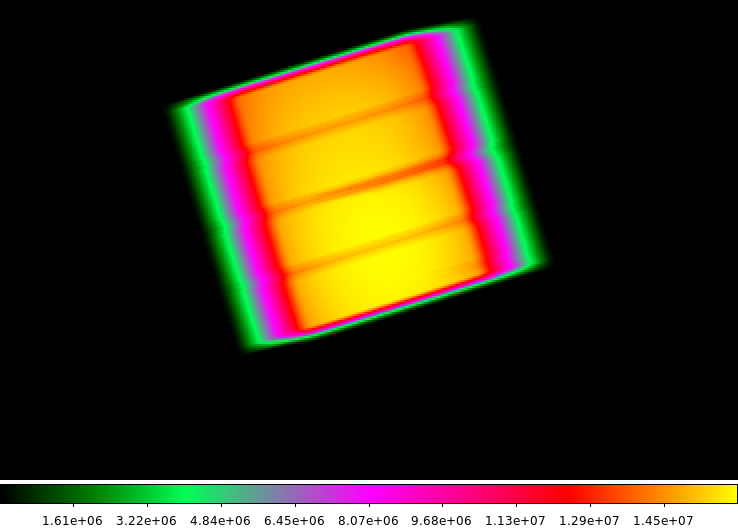

In [14]:
ds9 3726_oc_expmap.fits -cmap a\
  -zoom 2 \
  -saveimage png ds9_03.png &
sleep 10
xpaset -p ds9 quit

display < ds9_03.png

In [15]:
pset dmimgcalc infile="3726_jupiter_oc.fits[bin ocx=2048:6144:#512,ocy=2048:6144:#512]"
pset dmimgcalc infile2=3726_oc_expmap.fits
pset dmimgcalc outfile=3726_oc_norm.fits
pset dmimgcalc operation=div
dmimgcalc mode=h clob+

[1] 31547
[1]+  Done                    ds9 3726_oc_norm.fits -scale log -zoom 4 -saveimage png ds9_04.png


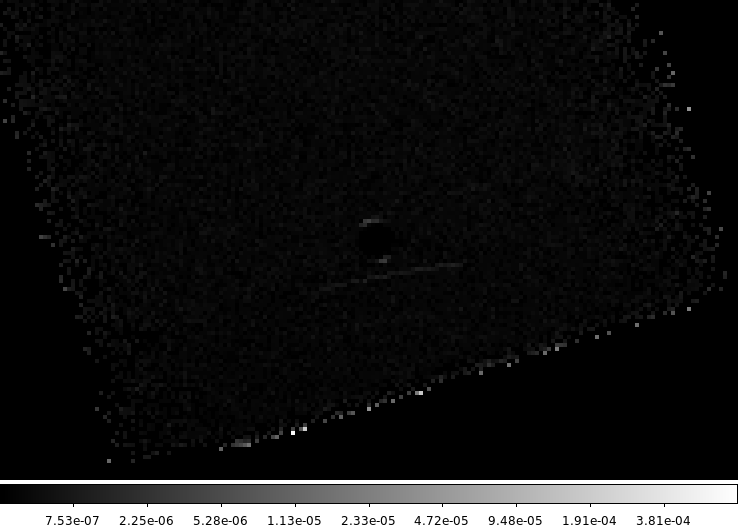

In [16]:
ds9 3726_oc_norm.fits -scale log \
    -zoom 4 \
    -saveimage png ds9_04.png &
sleep 10
xpaset -p ds9 quit

display < ds9_04.png

## Confirm accuracy

In [17]:
dmtcalc 3726_oc_asol1.fits 3726_oc180_asol1.fits \
      expression="if(ocra>180)then(ocra=ocra-360.0)" clob+

In [18]:
dmstat 3726_oc180_asol1.fits"[cols ocra]" verb=0
pget dmstat out_min out_max

-0.031108391089
0.012724649401


In [19]:
dmstat 3726_oc180_asol1.fits"[cols ocdec]" verb=0
pget dmstat out_min out_max

-0.012529705774
-0.00031648365187


In [20]:
dmcopy "3726_oc180_asol1.fits[bin ocra=-0.032:0.02:.0001,ocdec=-0.02:0.0:.0001]" \
      3726_oc_radec.img clob+


In [21]:
dmstat 3726_oc180_asol1.fits"[cols ra]" verb=0
pget dmstat out_min out_max

132.93131506
132.93721088


In [22]:
dmstat 3726_oc180_asol1.fits"[cols dec]" verb=0
pget dmstat out_min out_max

18.513642921
18.519299402


In [23]:
dmcopy "3726_oc180_asol1.fits[bin ra=132.931:132.938:.00001,dec=18.512:18.520:.00001]" \
      3726_targ_radec.img clob+

[1] 31657
[1]+  Done                    ds9 -scale log 3726_targ_radec.img -block 2 3726_oc_radec.img -block 0.5 -saveimage png ds9_05.png


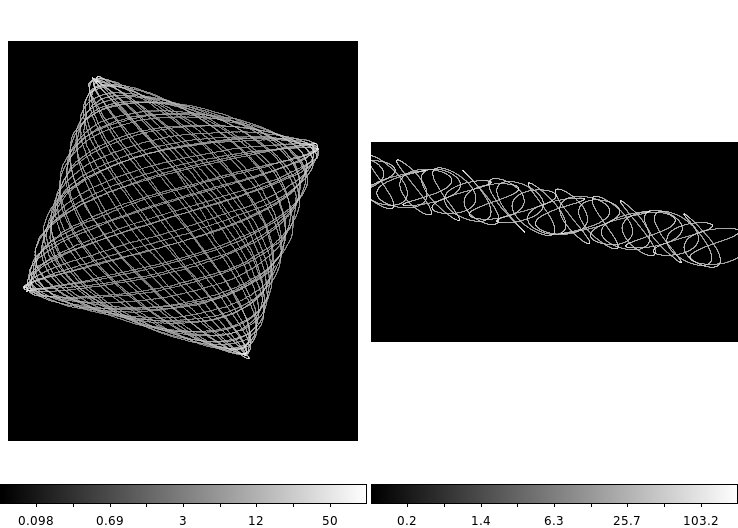

In [24]:
ds9 -scale log \
  3726_targ_radec.img -block 2 \
  3726_oc_radec.img -block 0.5 \
  -saveimage png ds9_05.png &
sleep 10
xpaset -p ds9 quit

display < ds9_05.png

In [25]:
cat << EOM > c1.py
tab = read_file("3726_oc180_asol1.fits")

times = tab.get_column("time").values
ra = tab.get_column("ra").values
dec = tab.get_column("dec").values
oc_ra = tab.get_column("ocra").values
oc_dec = tab.get_column("ocdec").values

add_window(1000,600, "pixels")
split(1,2,0,0.04)

colors = ['2C4561', '68948E', '726780', 'BAAA6F', 'BDC297']
npts = len(colors)

grid = np.linspace(0, len(times)-1, npts+1, dtype="i")
lo = grid[:-1]
hi = grid[1:]

crv = ChipsCurve()
crv.line.style="solid"
crv.symbol.style="none"
crv.line.thickness=2

for ii in range(npts):
    crv.line.color=colors[ii]
    crv.symbol.color=colors[ii]
    set_current_plot("plot1")
    add_curve( ra[lo[ii]:hi[ii]],dec[lo[ii]:hi[ii]], crv )
    set_current_plot("plot2")
    add_curve( oc_ra[lo[ii]:hi[ii]],oc_dec[lo[ii]:hi[ii]], crv )


set_current_plot("plot1")
reverse_axes(X_AXIS) 
set_plot_xlabel(r"\alpha")
set_plot_ylabel(r"\delta")
set_plot_title("Aspect Solution")

set_current_plot("plot2")
move_axis("ay1", 1,0)
set_plot_xlabel(r"Object Centered \alpha")
set_plot_ylabel(r"Object Centered \delta")
set_plot_title("Object Centered Aspect Solution")
reverse_axes(X_AXIS) 

print_window("chips_01.png", "export.clobber=True")
quit()
EOM

###chips -b c1.py
###display < chips_01.png



## Event data vs OC aspect


In [26]:
/bin/rm -f sso_track
curl -O https://cxc.cfa.harvard.edu/ciao/threads/ssoaspect/sso_track
chmod +x ./sso_track


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1354  100  1354    0     0   5175      0 --:--:-- --:--:-- --:--:--  5167


In [27]:
./sso_track 3726_oc_asol1.fits 10 sso.reg

ocsol, nreg are: 3726_oc_asol1.fits 10
nrows is 120865  
dt is 13429.4444
ssora,dec are: 132.9658671282 18.5195749695
ssora,dec are: 132.9609329984 18.5202451938
ssora,dec are: 132.9560468016 18.5209561862
ssora,dec are: 132.9512045626 18.5217051671
ssora,dec are: 132.9464037802 18.5224893790
ssora,dec are: 132.9416409073 18.5233065438
ssora,dec are: 132.9369141861 18.5241544081
ssora,dec are: 132.9322207554 18.5250312062
ssora,dec are: 132.9275594288 18.5259351345
ssora,dec are: 132.9229282045 18.5268647788


[1] 31934
[1]+  Done                    ds9 -scale log 3726_jupiter_oc.fits -bin factor 2 -region sso.reg 3726_oc_radec.img -orient x -saveimage png ds9_06.png


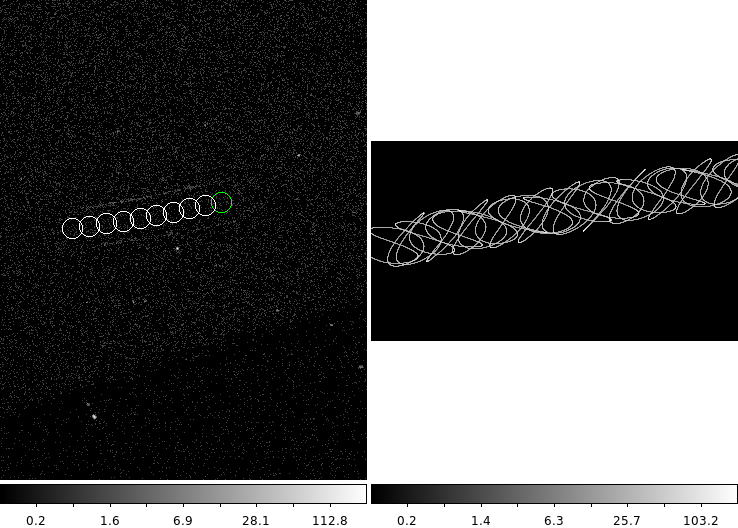

In [28]:
ds9 -scale log 3726_jupiter_oc.fits -bin factor 2 -region sso.reg \
  3726_oc_radec.img -orient x \
  -saveimage png ds9_06.png &
sleep 10
xpaset -p ds9 quit


display < ds9_06.png

# Cleanup


In [29]:
/bin/rm -rf 3726
/bin/rm -f acisf* pcadf* *eph1.fits 